# IBM Data Science Professional Certification Capstone

This notebook contains work towards satisfying the final requirements for this Coursera certification. It involves a location data analysis project which studies economic measures of Caribbean countries and prices of various commodities as acquired from the Foursquare API. I will attempt to establish whether there is a connection between these prices and two different measures of GDP.   

Full details of the project including motivation, results, and conclusions are available in the report which should exist in this same GitHub repository.

In [1]:
#!pip install folium

In [2]:
#!pip install ipympl

In [3]:
import pandas as pd
import numpy as np
import requests as rq
import re
import io
import lxml
import folium
import matplotlib.pyplot as plt
import sklearn
from bs4 import BeautifulSoup
from mpl_toolkits.mplot3d import Axes3D
from pandas.io.json import json_normalize
from datetime import date
%matplotlib inline

## Data Acquisition and Preparation

There are three main components to the data we will need for the analysis: 
1) Capital city coorinates  
2) Country GDP data  
3) Foursuare location data for each capital city  

The capital city coordinates and the GDP data are available from lmnixon.org and wikipedia.org respectively. The data tables will be harvested from the web and parsed using the BeautifulSoup package. These data will then be cleaned and made uniform. Finally, the coordinates and GDP data will be merged for each country.  
  
The Foursquare location data will be obtained using the Foursquare API, which requires the coordinates of each location to be queried. Averages will be taken for price ratings of different commodities for each capital, and the price data will be combined with the coordinate and GDP data.



### Import world capital coodrinates

The coordinates data is sourced from the website in the URL before. I use the BeautifulSoup package to pars the scraped data into human-readable text, to be formatted.

In [4]:
coord_url = "https://lab.lmnixon.org/4th/worldcapitals.html"
text_data = rq.get(coord_url).text
soup = BeautifulSoup(text_data,"html.parser")
#print(soup.prettify())

I isolate any tables from the scraped text data. I know that the data is in the first (only) table on that page, so I select the first element of the data (otherwise I would have to index a nested object every time, since soup.find_all() returned a list of one element.

In [5]:
text = soup.find_all("table")
print("{} tables found".format(len(text)))
table = text[0]

1 tables found


Next I want to use my knowledge of the parsed html data structure to identify data rows. The first row is the head, which I want to process into headings, but this table had unusual header formatting so I input the headings manually.

In [6]:
body = table.find_all("tr")
head = body[0]
body_rows = body[1:]

headings = ["Country", "Capital", "Latitude", "Longitude"]
#for item in head.find_all("th"):
#    item = (item.text).rstrip("\n")
#    headings.append(item)
#print(headings)

Check that the rows seem to contain the right information...

In [7]:
body_rows[0]

<tr>
<td>Afghanistan</td>
<td>Kabul</td>
<td>34.28N</td>
<td>69.11E</td>
</tr>

..and do some cleaning to remove the web formatting elements. After that, take a look at a few of the cleaned data entries.

In [8]:
all_rows = []

for row_num in range (len(body_rows)):
    row = []
    for row_item in body_rows[row_num].find_all("td"):
        datum = re.sub("(\xa0)|(\n),","",row_item.text)
        datum = re.sub("\n","",datum)
        row.append(datum)
    all_rows.append(row)

In [9]:
all_rows[0:5]

[['Afghanistan', 'Kabul', '34.28N', '69.11E'],
 ['Albania', 'Tirane', '41.18N', '19.49E'],
 ['Algeria', 'Algiers', '36.42N', '03.08E'],
 ['American Samoa', 'Pago Pago', '14.16S', '170.43W'],
 ['Andorra', 'Andorra la Vella', '42.31N', '01.32E']]

Looks good, so I convert it all to a dataframe using pandas. I'll look at the top and bottom of the dataframe to check them for any extraneous elements.

In [10]:
coord_frame = pd.DataFrame(data=all_rows, columns = headings)
coord_frame.head()

,Country,Capital,Latitude,Longitude
0,Afghanistan,Kabul,34.28N,69.11E
1,Albania,Tirane,41.18N,19.49E
2,Algeria,Algiers,36.42N,03.08E
3,American Samoa,Pago Pago,14.16S,170.43W
4,Andorra,Andorra la Vella,42.31N,01.32E


In [11]:
coord_frame.tail()

,Country,Capital,Latitude,Longitude
198,Zambia,Lusaka,15.28S,28.16E
199,Zimbabwe,Harare,17.43S,31.02E
200,,,,
201,,,:: to Fourth Grade page »,None
202,,,:: to Lab homepage »,None


Some extra text was caught up in the table formatting. Simply delete these rows.

In [12]:
coord_frame.drop([202,201,200], inplace=True)

The latitude and longitude are recorded as strings, but later we will need integers. I will map West and South values to negative values while casting all values to floats.

In [13]:
Latitude = []
for i in range(len(coord_frame["Latitude"])):
    lat = coord_frame["Latitude"][i]
    if "N" in lat:
        lat=float(re.sub("N","",lat))
        Latitude.append(lat)
    elif "S" in lat:
        lat=-1*float(re.sub("S","",lat))
        Latitude.append(lat)
        
Longitude = []
for i in range(len(coord_frame["Longitude"])):
    lon = coord_frame["Longitude"][i]
    if "E" in lon:
        lon=float(re.sub("E","",lon))
        Longitude.append(lon)
    elif "W" in lon:
        lon=-1*float(re.sub("W","",lon))
        Longitude.append(lon)

In [14]:
coord_frame["Latitude"]=Latitude
coord_frame["Longitude"]=Longitude
coord_frame.head()

,Country,Capital,Latitude,Longitude
0,Afghanistan,Kabul,34.28,69.11
1,Albania,Tirane,41.18,19.49
2,Algeria,Algiers,36.42,3.08
3,American Samoa,Pago Pago,-14.16,-170.43
4,Andorra,Andorra la Vella,42.31,1.32


This now looks like data I can use. I'll leave it alone for now, until I'm ready to merge it with the GDP data. There are a lot of unnecessary columns, but those will go away when we consilidate the data.

## Import and process GDP Data

Lists of Caribbean and Latin American countries with respective GDP are available from Wikipedia. Tables on different pages record the nominal and PPP values of GDP separately, so I will import them both.

In [15]:
nom_url = "https://en.wikipedia.org/wiki/List_of_Latin_American_and_Caribbean_countries_by_GDP_(nominal)"
ppp_url = "https://en.wikipedia.org/wiki/List_of_Latin_American_and_Caribbean_countries_by_GDP_(PPP)"

It is convenient at this point to define a function that will import and parse tables from Wiipedia pages. For generality, I will make it flexible in web formatting and which table to select, but preset default values for both.

In [16]:
def nth_wiki_table(url, tb_format = "lxml", n = 1):
    data = rq.get(url).text
    soup = BeautifulSoup(data,tb_format)
    table = soup.find_all("table")[n-1]
    body = table.find_all("tr")
    
    
    head = body[0]
    body_rows = body[1:]

    headings = []
    for item in head.find_all("th"):
        item = (item.text).rstrip("\n")
        headings.append(item)
        
    all_rows = []        
    for row_num in range (len(body_rows)):
        row = []
        for row_item in body_rows[row_num].find_all("td"):
            datum = re.sub("(\xa0)|(\n),","",row_item.text)
            datum = re.sub("\n","",datum)
            row.append(datum)
        all_rows.append(row)
    
    frame = pd.DataFrame(data=all_rows, columns=headings)
    
    #print(headings)
    return frame
    #print(all_rows)

In [17]:
nom_frame = nth_wiki_table(nom_url)
ppp_frame = nth_wiki_table(ppp_url)

In [18]:
nom_frame.head()

,Rank,Country,GDP (millions of US$),GDP percapita (US$)
0,1,Brazil,"1,363,767","6,450"
1,2,Mexico,"1,040,372","8,069"
2,3,Argentina,"382,760","8,433"
3,4,Colombia,"264,933","5,207"
4,5,Chile,"245,414","12,612"


In [19]:
ppp_frame.head()

,Rank,Country,GDP (PPP) in millions(Intl$),GDP (PPP) per capita(Intl$)
0,1,Brazil,"3,524,064","16,727"
1,2,Mexico,"2,696,454","21,412"
2,3,Argentina,"922,951","20,482"
3,4,Colombia,"791,995","15,720"
4,5,Chile,"507,939","27,059"


Before I combine them, I want to check that the tables have the same entries. I find that one table has one more entry than the other. I identify the extra entry. Since I don't need that country for this analysis (discussed elsewhere) I can remove it. (Spoiler: I don't have to remove it because the implicit join performed by merge() only keeps common values in the specified field.)

In [20]:
print("Nominal data has shape ", nom_frame.shape,
      " and PPP has shape ", ppp_frame.shape)

Nominal data has shape  (33, 4)  and PPP has shape  (34, 4)


In [21]:
diff = set(ppp_frame["Country"])-set(nom_frame["Country"])
diff

{'Puerto Rico[2][3]'}

In [22]:
ppp_frame = ppp_frame[ppp_frame["Country"] != list(diff)[0]]


In [23]:
print("Nominal data has shape ", nom_frame.shape,
      " and PPP has shape ", ppp_frame.shape)

Nominal data has shape  (33, 4)  and PPP has shape  (33, 4)


In [24]:
diff1 = set(ppp_frame["Country"])-set(nom_frame["Country"])
diff2 = set(nom_frame["Country"])-set(ppp_frame["Country"])
print(diff1,diff2)

set() set()


In [25]:
gdp_frame = nom_frame.merge(ppp_frame, on="Country")
gdp_frame.head()

,Rank_x,Country,GDP (millions of US$),GDP percapita (US$),Rank_y,GDP (PPP) in millions(Intl$),GDP (PPP) per capita(Intl$)
0,1,Brazil,"1,363,767","6,450",1,"3,524,064","16,727"
1,2,Mexico,"1,040,372","8,069",2,"2,696,454","21,412"
2,3,Argentina,"382,760","8,433",3,"922,951","20,482"
3,4,Colombia,"264,933","5,207",4,"791,995","15,720"
4,5,Chile,"245,414","12,612",5,"507,939","27,059"


Not bad, but I don't need all of it. The rankings are not important, and the gross GDP (of both kinds) is not as useful as the per capita values. Remove the extra data, then sort the dataframe by country name. The index will be changed later and it is not importent to keep this index in order.

In [26]:
gdp_frame.columns

Index(['Rank_x', 'Country', 'GDP (millions of US$)', 'GDP percapita (US$)',
       'Rank_y', 'GDP (PPP) in millions(Intl$)',
       'GDP (PPP) per capita(Intl$)'],
      dtype='object')

In [27]:
labels = [gdp_frame.columns[0], gdp_frame.columns[2], gdp_frame.columns[4],
          gdp_frame.columns[5]]
gdp_frame.drop(columns=labels,inplace=True)
gdp_frame = gdp_frame[gdp_frame["Country"]!="Total"]
gdp_frame.head()

,Country,GDP percapita (US$),GDP (PPP) per capita(Intl$)
0,Brazil,"6,450","16,727"
1,Mexico,"8,069","21,412"
2,Argentina,"8,433","20,482"
3,Colombia,"5,207","15,720"
4,Chile,"12,612","27,059"


In [28]:
gdp_frame.sort_values(by="Country",inplace=True)
gdp_frame.head()

,Country,GDP percapita (US$),GDP (PPP) per capita(Intl$)
27,Antigua and Barbuda,"14,159","27,542"
2,Argentina,"8,433","20,482"
23,Barbados,"16,082","18,866"
26,Belize,"3,734","8,467"
13,Bolivia,"3,322","8,320"


Don't forget to make sure our numbers are stored as numbers. The aren't, so I remove the comma and cast to integers. Another useful function is defined. I take the opportunity to change the column titles.   

Note: We lose the units of the GDP columns. We'll eventually normalize the data anyway, so as long as each column is self-consistent, the unit's don't matter.

In [29]:
gdp_frame.dtypes

Country                        object
GDP percapita (US$)            object
GDP (PPP) per capita(Intl$)    object
dtype: object

In [30]:
def str_to_int(frame, column, new_col_name):
    new_col=[]
    for string in gdp_frame[column]:
        integer = int(re.sub(",","",string))
        new_col.append(integer)
    frame[new_col_name] = new_col
    frame.drop(columns=column, inplace=True)
    return frame
        

In [31]:
str_to_int(gdp_frame, "GDP (PPP) per capita(Intl$)", "GDP (PPP) per capita")
print("Done!")

Done!


In [32]:
str_to_int(gdp_frame, "GDP percapita (US$)", "GDP (nominal) per capita")
print("Done!")

Done!


In [33]:
gdp_frame.head()

,Country,GDP (PPP) per capita,GDP (nominal) per capita
27,Antigua and Barbuda,27542,14159
2,Argentina,20482,8433
23,Barbados,18866,16082
26,Belize,8467,3734
13,Bolivia,8320,3322


This is a usable format.

## Combine GDP and coordinates, Isolate Caribbean Countries

When we combine the two dataframes, only rows with the chosen value (country) in both frames will be kept. Before I merge them, I will check that the countries of interest are recorded in the same way in both dataframes.  

I have chosen to use those Caribbean countries which are members of the regional body CARICOM. This gives an unambiguous definition of the places of interest we want to keep. After listing those countries, I check both dataframes and note anomalies. Since these are relatively small frames I can check manually. Computationally searching for misspellings is difficult and unneeded here.

In [34]:
caricom = ["Antigua and Barbuda", "The Bahamas", "Barbados", "Belize", "Dominica", 
           "Grenada", "Guyana", "Haiti", "Jamaica", "Montserrat", 
           "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines",
           "Suriname", "Trinidad and Tobago"]


In [35]:
print(gdp_frame["Country"])

27                 Antigua and Barbuda
2                            Argentina
23                            Barbados
26                              Belize
13                             Bolivia
0                               Brazil
4                                Chile
3                             Colombia
10                          Costa Rica
31                            Dominica
7                   Dominican Republic
6                              Ecuador
15                         El Salvador
28                             Grenada
8                            Guatemala
22                              Guyana
21                               Haiti
16                            Honduras
18                             Jamaica
1                               Mexico
19                           Nicaragua
9                               Panama
14                            Paraguay
5                                 Peru
29               Saint Kitts and Nevis
25                       

Notes:  
"The " in Bahamas  
No Montserrat  
"Saint", not "St." in all cases  

In [36]:
pd.options.display.max_rows=300
print(coord_frame["Country"])

0                                            Afghanistan
1                                                Albania
2                                                Algeria
3                                         American Samoa
4                                                Andorra
5                                                 Angola
6                                    Antigua and Barbuda
7                                              Argentina
8                                                Armenia
9                                                  Aruba
10                                             Australia
11                                               Austria
12                                            Azerbaijan
13                                               Bahamas
14                                               Bahrain
15                                            Bangladesh
16                                              Barbados
17                             

Notes:  
"Saint", not "St." in all cases  
"Greenadines" misspelled  
No "The" in Bahamas  
No Grenada  
No Montserrat  
No Trinidad and Tobago  

Rename countries as needed, then check that the changes were applied.

In [37]:
coord_frame.at[158,"Country"] = "Saint Vincent and the Grenadines"
coord_frame.at[13, "Country"] = "The Bahamas"

In [38]:
coord_frame.loc[158]

Country      Saint Vincent and the Grenadines
Capital                             Kingstown
Latitude                                 13.1
Longitude                               -61.1
Name: 158, dtype: object

Two countries were missing from the coordinate data. It is a simple matter to look up the data from elsewhere and add new rows to that dataframe.

In [39]:
grenada = ["Grenada", "Saint George's", 12.05, -61.75]
trinidad = ["Trinidad and Tobago", "Port of Spain", 10.67, -61.52]

In [40]:
coord_frame.loc[len(coord_frame)] = grenada
coord_frame.loc[len(coord_frame)] = trinidad

In [41]:
coord_frame.tail()

,Country,Capital,Latitude,Longitude
197,Yugoslavia,Belgrade,44.50,20.37
198,Zambia,Lusaka,-15.28,28.16
199,Zimbabwe,Harare,-17.43,31.02
200,Grenada,Saint George's,12.05,-61.75
201,Trinidad and Tobago,Port of Spain,10.67,-61.52


Finally, merge() the two frames. Only countries on both lists are kept. Then, pare down the data again by comparing against the CARICOM list defined above. Since we removed one location in a step above, it will not be in the final list. Finally, the country names will make a more sensible index than meaningless integers.

(I noticed an error in one of the capital names, so I fixed that as well.)

In [42]:
gdp_coord_frame = gdp_frame.merge(coord_frame, on="Country")
gdp_coord_frame

,Country,GDP (PPP) per capita,GDP (nominal) per capita,Capital,Latitude,Longitude
0,Antigua and Barbuda,27542,14159,West Indies,17.20,-61.48
1,Argentina,20482,8433,Buenos Aires,-36.30,-60.00
2,Barbados,18866,16082,Bridgetown,13.05,-59.30
3,Belize,8467,3734,Belmopan,17.18,-88.30
4,Bolivia,8320,3322,La Paz (administrative) / Sucre (legislative),-16.20,-68.10
5,Brazil,16727,6450,Brasilia,-15.47,-47.55
6,Chile,27059,12612,Santiago,-33.24,-70.40
7,Colombia,15720,5207,Bogota,4.34,-74.00
8,Costa Rica,18394,11629,San Jose,9.55,-84.02
9,Dominica,9726,7709,Roseau,15.20,-61.24


In [43]:
gdp_coord_frame.at[0,"Capital"] = "Saint John's"

In [44]:
gdp_coord_frame = gdp_coord_frame[gdp_coord_frame["Country"].isin(caricom)]

In [45]:
gdp_coord_frame.set_index("Country",inplace=True)

In [46]:
gdp_coord_frame

,GDP (PPP) per capita,GDP (nominal) per capita,Capital,Latitude,Longitude
Country,,,,,
Antigua and Barbuda,27542,14159,Saint John's,17.20,-61.48
Barbados,18866,16082,Bridgetown,13.05,-59.30
Belize,8467,3734,Belmopan,17.18,-88.30
Dominica,9726,7709,Roseau,15.20,-61.24
Grenada,16033,9824,Saint George's,12.05,-61.75
Guyana,8524,8649,Georgetown,6.50,-58.12
Haiti,1940,732,Port-au-Prince,18.40,-72.20
Jamaica,9726,5221,Kingston,18.00,-76.50
Saint Kitts and Nevis,29098,15246,Basseterre,17.17,-62.43


We should now be prepared to use the coordinates to obtain our location data from the Foursquare API.  

Before that, we can use the folium package to create a simple map. We show circles for each capital, where the radius of each circle reflects the scaled GDP (PPP).

In [47]:
m = folium.Map(location =[16.5,-73.5], zoom_start=5)



for index, row in gdp_coord_frame.iterrows():
    folium.CircleMarker(location=(row["Latitude"],row["Longitude"]),
                        radius=row["GDP (PPP) per capita"]/5000,
                        color="black",
                        fill=True,
                        fill_color="black",
                        label=row["Capital"]).add_to(m)
    #folium.Marker(location=(row["Latitude"],row["Longitude"]),
     #            popup=row["Capital"]).add_to(m)

m

## Fetch data from Foursquare API

Now we use the coordinate data to acquire data about venues in and around each capital. These data, when processed, will constitute the explanatory variables for the models we construct later. The GDP data will form the dependent variables.  

There are lots of comments in this section! Some parts are used for debugging and for tuning, and some comments are just for explanation. 

First, define some variables which will be needed for the API data. These are my credentials, use your own! (Mine should be hidden.)

In [48]:
# @hidden_cell
CLIENT_ID = 'M1KFHKQKC3XJB3AI0RRLNVQ14UIYDWMTS2VTMSRJPJFPIF4H' # your Foursquare ID
CLIENT_SECRET = 'E3FGIQBVTXIU5DFACSE1OQARY1Q0E1ZUART05SDHMJENZCHJ' # your Foursquare Secret
ACCESS_TOKEN = 'EQ3AMHUTN0W2JFVFS1DQ4OIS2FT3VBZ2GJPBXEKOI15QEQ20' # your FourSquare Access Token
#VERSION = '20180604'
VERSION = '20210131'
LIMIT = 20
RADIUS = 3000 #generous radius in case coordinates are slightly off. not actually used below.

    
  
I'm going to collect price data on multiple categories of business covered by Foursquare. Here I define the list of categories I will  use. 

I'm severely limited by the number of premium API calls (needed to get price data) so I only use the subset of the categories which provide the most price data. You may notice that this required some testing to refine the list...    

Here I also define the list of countries to search over. Because of the API call quota, I will collect the data over multiple days.

In [49]:
all_countries  = gdp_coord_frame.index.values
countries_day1 = all_countries[range(0,5)]
countries_day2 = all_countries[range(5,10)]
countries_day3 = all_countries[range(10,14)]

#cats      = ["Arts & Entertainment", "Food", "Shop & Service", "Nightlife Spot", "Outdoor and Recreation"]
#cat_ids   = ["4d4b7104d754a06370d81259", "4d4b7105d754a06374d81259", "4d4b7105d754a06378d81259","4d4b7105d754a06376d81259","4d4b7105d754a06377d81259"]

cats      = ["Food", "Nightlife Spot"]
cat_ids   = ["4d4b7105d754a06374d81259","4d4b7105d754a06376d81259"]

In [50]:
# another debug cell
#cat_ids = ["4d4b7105d754a06375d81259","4d4b7105d754a06379d81259"]
#cats = ["professional","travel"]


This cell contains the code by which I make the API calls and construct dataframes to work with. The cells which follow are light associated processing. I have run the code several times over several days, and the data has been compiled and saved. To avoid wasting time and API calls, I am leaving the next few cells commented and simply import the data I have already collected. If the relevant file is not at hand, the data can be reproduced using the cell below.

In [51]:
# ## The cell is the MEAT. Leave it commented while debugging. USES A LOT OF API CALLS

# ######### DEBUG Section
# #countries = ["Barbados","Jamaica","The Bahamas"]
# #cat_ids = ["4d4b7104d754a06370d81259"] #arts and entertainment
# #cat_ids = ["4d4b7105d754a06374d81259"] #food
# #cat_ids = ["4d4b7105d754a06378d81259"]  #shop and service
# #cat_ids = ["4d4b7105d754a06377d81259"] #outdoors and recreation
# #cat_ids = ["4d4b7105d754a06375d81259"] #professional and other places
# #cat_ids = ["4d4b7105d754a06379d81259"] #travel and transport
# #cat_ids = ["4d4b7105d754a06376d81259"] #nightlife spot
# ######### end debug section 

# countries  = countries_day3
# name      = "day3"
# price_data = pd.DataFrame(index=countries)
# for country in countries:
    

#     j = 0   #counts categories, since there are 2 category lists (cats and cat_ids)
    
#     for category in cat_ids:
        
#         prices = []        
#         #get (LIMIT) venues from each category
#         LATITUDE   = gdp_coord_frame.loc[country,"Latitude"]
#         LONGITUDE  = gdp_coord_frame.loc[country,"Longitude"]
#         search_url = "https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&v={}&limit={}".format(category,CLIENT_ID,CLIENT_SECRET,LATITUDE,LONGITUDE,VERSION,LIMIT)
#         #search_url = "https://api.foursquare.com/v2/search/recommendations?categoryId={}&client_id={}&client_secret={}&ll={},{}&v={}&limit={}".format(category,CLIENT_ID,CLIENT_SECRET,LATITUDE,LONGITUDE,VERSION,LIMIT)
#         #Experimented with the recommendations endpoint. did not need it after all
#         venues     = rq.get(search_url).json()
#         venues     = venues["response"]["venues"]   # separated from the line above for debugging
#         #price_tier = venues["price"]["tier"]
#         venue_data = pd.json_normalize(venues)   #this is now a dataframe
        
#         #i=0
#         if venue_data.empty==False:   # skips if no venues returned b search
#             for i in range(len(venue_data["id"])):
#             #while len(prices)<5 and i<5: #try up to LIMIT times to get 5 price data
#                 ID          = venue_data.iloc[i]["id"]
#                 details_url = "https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}".format(ID,CLIENT_ID,CLIENT_SECRET,VERSION)
#                 output      = rq.get(details_url).json()

#                 try:      # just in case there is no price data for a particular location
#                     price_tier = output["response"]["venue"]["price"]["tier"]
#                     prices.append(price_tier)
#                 except: 
#                     continue
#                 #i=i+1
#             avg_price = np.mean(prices) # what if none of the venues have price data? avg_price = nan ? I hope this doesn't happen...
#             price_data.at[country,cats[j]] = avg_price
#             j = j+1
#         #all_prices.append(price_data)


In [52]:
#debug cell. uncomment an item to check the most recent result

#venues
#all_prices
#price_data
#prices
#output["response"]["venue"]["price"]
#output
#venues[0:3]
#search_url
#cat_ids
#venue_data 

In [53]:
#price_data.to_csv("{}-{}.csv".format(name,date.today()))

In [54]:
# price_frame1 = pd.read_csv("day1-2021-02-07.csv")
# price_frame2 = pd.read_csv("day2-2021-02-08.csv")
# price_frame3 = pd.read_csv("day3-2021-02-08.csv")
# #price_frame = price_data      # use if the get requests have been executed in this session

In [55]:
#all_price_data = (price_frame1.append(price_frame2)).append(price_frame3)

In [56]:
#all_price_data

In [57]:
# all_price_data.rename(columns={"Unnamed: 0" : "Country"},inplace = True)
# all_price_data.rename(columns={"Food" : "Food average price tier"},inplace = True)
# all_price_data.rename(columns={"Nightlife Spot" : "Nightlife average price tier"},inplace = True)
# all_price_data.set_index("Country",inplace=True)

In [58]:
#all_price_data

Finally, add the price data to the coordinate and GDP data.

In [59]:
# final_frame = gdp_coord_frame.join(all_price_data) 
# #final_frame

In [60]:
# final_frame.drop("Saint Lucia", inplace=True)
# final_frame

In [61]:
#final_frame.to_csv("my_data.csv")

In [62]:
final_frame = (pd.read_csv("my_data.csv")).set_index("Country") 
final_frame

,GDP (PPP) per capita,GDP (nominal) per capita,Capital,Latitude,Longitude,Food average price tier,Nightlife average price tier
Country,,,,,,,
Antigua and Barbuda,27542,14159,Saint John's,17.20,-61.48,1.894737,2.400000
Barbados,18866,16082,Bridgetown,13.05,-59.30,1.526316,1.875000
Belize,8467,3734,Belmopan,17.18,-88.30,1.500000,2.500000
Dominica,9726,7709,Roseau,15.20,-61.24,1.736842,2.357143
Grenada,16033,9824,Saint George's,12.05,-61.75,1.722222,1.947368
Guyana,8524,8649,Georgetown,6.50,-58.12,1.125000,2.200000
Haiti,1940,732,Port-au-Prince,18.40,-72.20,1.600000,2.312500
Jamaica,9726,5221,Kingston,18.00,-76.50,1.277778,2.066667
Saint Kitts and Nevis,29098,15246,Basseterre,17.17,-62.43,1.894737,2.125000


In [63]:
m2 = folium.Map(location =[16.5,-73.5], zoom_start=5)


circle_scale = 5
for index, row in final_frame.iterrows():
    folium.CircleMarker(location=(row["Latitude"],row["Longitude"]),
                        radius=row["Food average price tier"]*circle_scale,
                        color="red",
                        fill=False,
                        #fill_color="green",
                        label=row["Capital"]).add_to(m2)
    #folium.Marker(location=(row["Latitude"],row["Longitude"]),
     #            popup=row["Capital"]).add_to(m)
for index, row in final_frame.iterrows():
    folium.CircleMarker(location=(row["Latitude"],row["Longitude"]),
                        radius=row["Nightlife average price tier"]*circle_scale,
                        color="blue",
                        fill=False,
                        #fill_color="blue",
                        label=row["Capital"]).add_to(m2)
m2

## Data Analysis

In this section I perform the analysis toward the goal of this project - to test whether GDP can be predicted by the costs of facilities in a given country's capital.  

I begin with some preliminary analysis, to get the "low-lying fruit" of the data - questions which bear asking but may not directly answer the primary question. These questions include whether the two types of gdp co-vary, and similar whether the prices of the measured commodities co-vary.  

Then, I'll proceed with the task at hand, creating a multiple regression model to attempt to predict the two types of GDP obtained above.

### Preliminary analysis - does PPP vary with nominal GDP?

In [64]:
from sklearn import linear_model, preprocessing,metrics

In [65]:
X = final_frame[["GDP (nominal) per capita"]]
Y = final_frame['GDP (PPP) per capita']

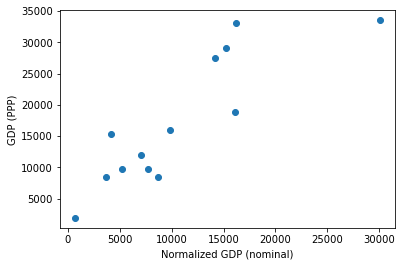

In [66]:
plt.scatter(X,Y);
plt.xlabel("Normalized GDP (nominal)")
plt.ylabel("GDP (PPP)");

In [67]:
scaler=preprocessing.MinMaxScaler()
#X = scaler.fit_transform(X)
lm = linear_model.LinearRegression()
lm.fit(X,Y)
yhat = lm.predict(X)

In [68]:
print("The regression score is ", lm.score(X,Y),". The X coefficient is ", lm.coef_[0], " and the intercept is ", lm.intercept_,".")

The regression score is  0.7408167052838734 . The X coefficient is  1.1606223931740351  and the intercept is  4821.744950671218 .


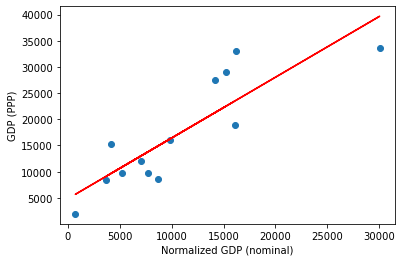

In [69]:
plt.scatter(X,Y)
plt.xlabel("Normalized GDP (nominal)")
plt.ylabel("GDP (PPP)")
plt.plot(X,yhat,color="red");
#plt.savefig("nom_ppp_fit.PNG")

### Preliminary analysis - are food venue prices and nightlife venue prices correlated?

In [70]:
X = final_frame[["Food average price tier"]]
Y = final_frame['Nightlife average price tier']

In [71]:
lm = linear_model.LinearRegression()
lm.fit(X,Y)
yhat = lm.predict(X)

In [72]:
print("The regression score is ", lm.score(X,Y),". The X coefficient is ", lm.coef_[0], " and the intercept is ", lm.intercept_,".")

The regression score is  0.07827242506917764 . The X coefficient is  0.25547652942691684  and the intercept is  1.7672443311505706 .


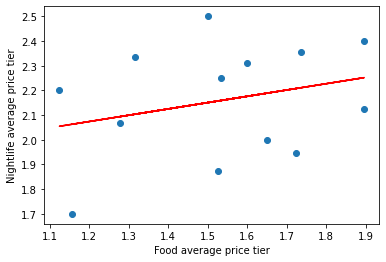

In [73]:
plt.scatter(X,Y)
plt.plot(X,yhat, color = "red");
plt.xlabel("Food average price tier")
plt.ylabel("Nightlife average price tier");
#plt.savefig("food_nightlife_fit.PNG")

The regression score here is very, very low. These values do not seem to be correlated.

### Main analysis - multiple regression

In [74]:
X     = final_frame[["Food average price tier","Nightlife average price tier"]]
Y_nom = final_frame["GDP (nominal) per capita"]/max(final_frame["GDP (nominal) per capita"])   #normalised GDP data
Y_ppp = final_frame["GDP (PPP) per capita"]/max(final_frame["GDP (PPP) per capita"])

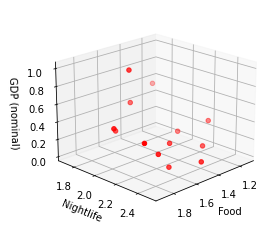

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.view_init(elev=20,azim=45)
ax.scatter(xs = final_frame["Food average price tier"],ys = final_frame["Nightlife average price tier"],zs=Y_nom,color = "red")
ax.set_xlabel("Food")
ax.set_ylabel("Nightlife")
ax.set_zlabel("GDP (nominal)");

By changing perspective, we can look directly a the relationship between Nightlife price and GDP. It looks like there is a trend, but an outlier may skew the result. We don't have much data and can't make assumptions about that point's validity, and I will leave it in.

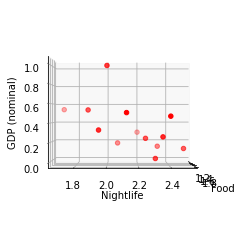

In [76]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.view_init(elev=0,azim=0)
ax.scatter(xs = final_frame["Food average price tier"],ys = final_frame["Nightlife average price tier"],zs=Y_nom,color = "red")
ax.set_xlabel("Food")
ax.set_ylabel("Nightlife")
ax.set_zlabel("GDP (nominal)");

Similarly, we can lok at Food vs GDP. The correlation, if any, is much less clear. Disregarding the outlying high-GDP point, there seems to be no real trend.

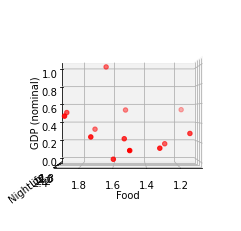

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.view_init(elev=0,azim=90)
ax.scatter(xs = final_frame["Food average price tier"],ys = final_frame["Nightlife average price tier"],zs=Y_nom,color = "red")
ax.set_xlabel("Food")
ax.set_ylabel("Nightlife")
ax.set_zlabel("GDP (nominal)");

To the regression, then. I worry that with so little data, doing a test/train split would result in too little data to build a good model. This will make evaluating the model difficult, and we will have to rely on the R^2 measure produced by training on all of the data.

In [78]:
scaler=preprocessing.MinMaxScaler()
X     = scaler.fit_transform(X)

lm_nom = linear_model.LinearRegression()
lm_nom.fit(X,Y_nom)
yhat_nom = lm_nom.predict(X)

lm_ppp = linear_model.LinearRegression()
lm_ppp.fit(X,Y_ppp)
yhat_ppp = lm_ppp.predict(X)

print("Regression done!")

Regression done!


#### Multiple regression results


I tried to plot the regression plane below, but failed. If you see what went wrong, feel free to let me know.

In [79]:
# gridmarks = np.linspace(0,1,13)
# xx, yy = np.array(np.meshgrid(gridmarks)), np.array(np.meshgrid(gridmarks))

# ytest = np.array(yhat_nom)

# fig = plt.figure()
# ax = fig.add_subplot(111,projection='3d')
# ax.plot_surface(xx,yy,ytest.reshape(xx.shape),color = "none",alpha=0.3);
# # ax2.set_xlabel("")
# # ax2.set_ylabel("")
# # ax2.set_zlabel("")

# #ax.scatter(xs=x1,ys=x2,zs=Y_nom,color = "red");

Anyway, here is a summary of the results of multiple regression:

In [80]:
print("Nominal GDP: \n")
print("Food coefficient: ", lm_nom.coef_[0])
print("Nightlife coefficient: ", lm_nom.coef_[1])
print("Intercept: ", lm_nom.intercept_)
print("Regression score: ", metrics.r2_score(Y_nom,yhat_nom),"\n \n")

print("PPP GDP: \n")
print("Food coefficient: ", lm_ppp.coef_[0])
print("Nightlife coefficient: ", lm_ppp.coef_[1])
print("Intercept: ", lm_ppp.intercept_)
print("Regression score: ", metrics.r2_score(Y_ppp,yhat_ppp))

Nominal GDP: 

Food coefficient:  0.3256526797627966
Nightlife coefficient:  -0.5885322820498852
Intercept:  0.5204827281817856
Regression score:  0.4636189573696111 
 

PPP GDP: 

Food coefficient:  0.3859255007662723
Nightlife coefficient:  -0.6844634428707504
Intercept:  0.7015595636442107
Regression score:  0.4331685319540177


The regression scores are certainly not overwhelming. I suspect I have overfit the model by including the Nightlife data, disguising the predictive effectiveness of the Food venue data. I should investigate further...

### Follow-up: simple linear regression for Food venue prices vs. GDP

I suspect that the Food venue prices may be a good predictor of out GDP values, but the multiple regression model masked this by fitting for a non-predictive variable. I'm going to perform a similar analysis using only that independent variable.

In [81]:
X     = final_frame[["Nightlife average price tier"]]
Y_nom = final_frame["GDP (nominal) per capita"]/max(final_frame["GDP (nominal) per capita"])    #normalised GDP data
Y_ppp = final_frame["GDP (PPP) per capita"]/max(final_frame["GDP (PPP) per capita"])

scaler=preprocessing.MinMaxScaler()
X     = scaler.fit_transform(X)

lm_nom = linear_model.LinearRegression()
lm_nom.fit(X,Y_nom)
yhat_nom = lm_nom.predict(X)

lm_ppp = linear_model.LinearRegression()
lm_ppp.fit(X,Y_ppp)
yhat_ppp = lm_ppp.predict(X)

print("Regression done!")

Regression done!


In [82]:
print("Nominal GDP: \n")
print("Nightlife coefficient: ", lm_nom.coef_[0])
print("Intercept: ", lm_nom.intercept_)
print("Regression score: ", metrics.r2_score(Y_nom,yhat_nom),"\n \n")

print("PPP GDP: \n")
print("Nightlife coefficient: ", lm_ppp.coef_[0])
print("Intercept: ", lm_ppp.intercept_)
print("Regression score: ", metrics.r2_score(Y_ppp,yhat_ppp))

Nominal GDP: 

Nightlife coefficient:  -0.48483672445660175
Intercept:  0.6337837542204188
Regression score:  0.30131142485083506 
 

PPP GDP: 

Nightlife coefficient:  -0.561575585720073
Intercept:  0.8358306995155367
Regression score:  0.2769812500940815


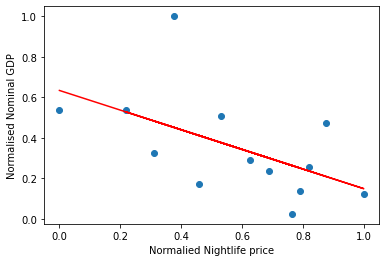

In [83]:
plt.scatter(X,Y_nom)
plt.xlabel("Normalied Nightlife price")
plt.ylabel("Normalised Nominal GDP")
plt.plot(X,yhat_nom,color="red");
#plt.savefig("N_nom_fit.PNG")

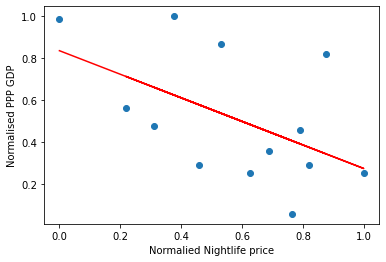

In [84]:
plt.scatter(X,Y_ppp)
plt.xlabel("Normalied Nightlife price")
plt.ylabel("Normalised PPP GDP")
plt.plot(X,yhat_ppp,color="red");
#plt.savefig("N_ppp_fit.PNG")

Even though it looked like there was a trend, the errors are high and the regression scores are low. It looks like the current data does not encourage use of food venue prices to predict GDP.